In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import random
import warnings
warnings.filterwarnings('ignore')

In [146]:
df = pd.read_csv('lung-cancer.csv', header=None)
output = open('Q2_output.txt', 'w')
for index in range(1, df.shape[1]):
    df.iloc[df.iloc[:, index] == '?', index] = df.iloc[:, index].mode()[0]
    df.iloc[:, index] = pd.to_numeric(df.iloc[:, index])

In [147]:
def scaler(X):
    for index in range(X.shape[1]):
        mean_val = X.iloc[:, index].mean()
        std_val = X.iloc[:, index].std()
        X.iloc[:, index] = (X.iloc[:, index] - mean_val) / std_val
    return X

def sampler(X, frac):
    row_index = random.sample(range(X.shape[0]),int(frac * X.shape[0]))
    return X.iloc[row_index, :]

In [148]:
X = df.iloc[:, 1:]
actual_val = df.iloc[:, 0]
X = scaler(X)
train_data = sampler(X, 0.8)
test_data = X.drop(train_data.index)
train_index = train_data.index.to_list()
train_val = actual_val.iloc[train_index]
test_val = actual_val.drop(train_val.index)

In [149]:
linear_svc = SVC(kernel='linear')
linear_svc.fit(train_data, train_val)
linear_pred_val = linear_svc.predict(test_data)
linear_accuracy = (test_val.values == linear_pred_val).sum() / test_val.size
print("The accuracy obtained for binary SVM classifier using linear kernel : ", linear_accuracy, file = output)

quadratic_svc = SVC(kernel='poly', degree=2)
quadratic_svc.fit(train_data, train_val)
quadratic_pred_val = quadratic_svc.predict(test_data)
quadratic_accuracy = (test_val.values == quadratic_pred_val).sum() / test_val.size
print("The accuracy obtained for binary SVM classifier using quadratic kernel : ", quadratic_accuracy, file = output)

rbf_svc = SVC(kernel='rbf')
rbf_svc.fit(train_data, train_val)
rbf_pred_val = rbf_svc.predict(test_data)
rbf_accuracy = (test_val.values == rbf_pred_val).sum() / test_val.size
print("The accuracy obtained for binary SVM classifier using radial basis function kernel : ", rbf_accuracy, file = output)

In [150]:
p1_MLP = MLPClassifier(hidden_layer_sizes=(16,), solver='sgd', learning_rate='constant',learning_rate_init=0.001, batch_size=32)
p1_MLP.fit(train_data, train_val)
p1_MLP_pred_val = p1_MLP.predict(test_data)
p1_MLP_accuracy = (test_val.values == p1_MLP_pred_val).sum() / test_val.size
print("\nThe accuracy obtained on the first MLP Classifier : ", p1_MLP_accuracy, file = output)

p2_MLP = MLPClassifier(hidden_layer_sizes=(256,16), solver='sgd', learning_rate='constant',learning_rate_init=0.001, batch_size=32)
p2_MLP.fit(train_data, train_val)
p2_MLP_pred_val = p2_MLP.predict(test_data)
p2_MLP_accuracy = (test_val.values == p2_MLP_pred_val).sum() / test_val.size
print("The accuracy obtained on the second MLP Classifier : ", p2_MLP_accuracy, file = output)

In [151]:
best_model = p1_MLP if p1_MLP_accuracy > p2_MLP_accuracy else p2_MLP
best_model_accuracy_list = []
learning_rate_list = []
learning_rate = 0.1
print("\nThe accuracy obtained for the respective learning rates on the best model are :", file = output)
for i in range(5):
    cur_model = best_model.set_params(learning_rate_init=learning_rate)
    cur_model.fit(train_data, train_val)
    cur_model_pred_val = cur_model.predict(test_data)
    cur_model_accuracy = (test_val.values == cur_model_pred_val).sum() / test_val.size
    best_model_accuracy_list.append(cur_model_accuracy)
    learning_rate_list.append(learning_rate)
    print(learning_rate, " : ", cur_model_accuracy, file = output)
    learning_rate /= 10

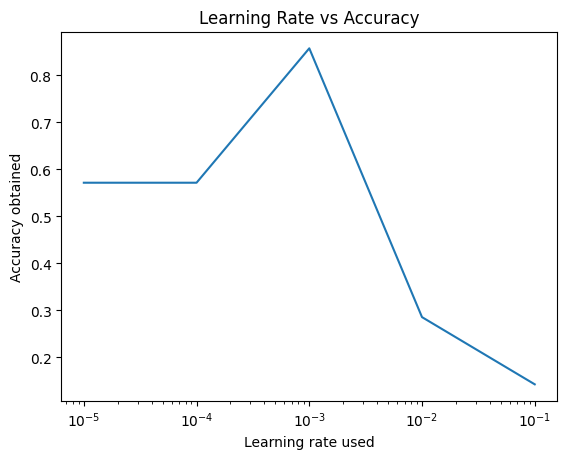

In [152]:
plt.xscale("log")
plt.plot(learning_rate_list, best_model_accuracy_list)
plt.xlabel('Learning rate used')
plt.ylabel('Accuracy obtained')
plt.title('Learning Rate vs Accuracy')
plt.savefig('Q2_plot.png')

In [153]:
def forward_feature_selection(train_data, test_data, train_val, test_val):
    col_select = {}
    test_df = pd.DataFrame()
    train_df = pd.DataFrame()
    col_train_data = {}
    col_test_data = {}
    best_acc = -1
    for i in range(train_data.shape[1]):
        col_train_data[i] = train_data[train_data.columns[i]].values.tolist()
        col_test_data[i] = test_data[test_data.columns[i]].values.tolist()
    for i in range(train_data.shape[1]):
        best_val = -1
        for j in range(train_data.shape[1]):
            if j in col_select:
                continue
            train_df.insert(0, str(j), col_train_data[j])
            test_df.insert(0, str(j), col_test_data[j])
            best_model.fit(train_df, train_val)
            best_model_pred_val = best_model.predict(test_df)
            best_model_accuracy = (test_val.values == best_model_pred_val).sum() / test_val.size
            if best_model_accuracy >= best_acc:
                best_acc = best_model_accuracy
                best_val = j
            test_df.drop(test_df.columns[[0]], axis=1, inplace=True)
            train_df.drop(train_df.columns[[0]], axis=1, inplace=True)
        if best_val == -1:
            break
        col_select[best_val] = 1
        train_df.insert(0, str(best_val), col_train_data[best_val])
        test_df.insert(0, str(best_val), col_test_data[best_val])
    index_list = [int(i) for i in train_df.columns]
    index_list.sort()
    return index_list

index_list = forward_feature_selection(train_data, test_data, train_val, test_val)
print("\nThe list of column indexes selected after applying Forward Feature Selection :\n", index_list, file = output)

In [ ]:
ensemble_pred_val = []
best_model_pred_val = p1_MLP_pred_val if p1_MLP_accuracy > p2_MLP_accuracy else p2_MLP_pred_val
for i in range(test_data.shape[0]):
    pred_val = [quadratic_pred_val[i], rbf_pred_val[i], best_model_pred_val[i]]
    ensemble_pred_val.append(max(set(pred_val), key=pred_val.count))
final_accuracy = (test_val.values == np.array(ensemble_pred_val)).sum() / test_val.size
print("\nThe final accuracy obtained after using ensemble learning with max voting technique is : ", final_accuracy, file = output)

In [ ]:
output.close()